In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()

unzip("archive.zip")

Found 6484 files belonging to 11 classes.


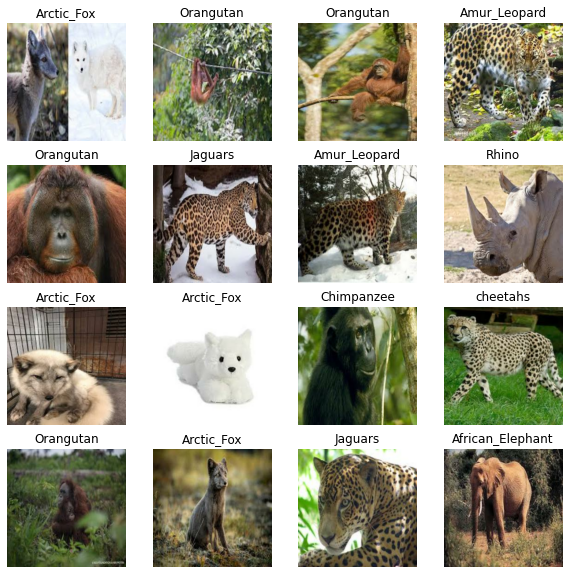

In [3]:
image = image_dataset_from_directory(
    directory = "Danger Of Extinction",
    seed = 42,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

class_names = image.class_names

plt.figure(figsize=(10,10))
for images,labels in image.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 10,
    validation_split = 0.2,
)

train_ds = datagen.flow_from_directory(
    directory = "Danger Of Extinction",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "training",
)

val_ds = datagen.flow_from_directory(
    directory = "Danger Of Extinction",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "validation",
)

Found 5190 images belonging to 11 classes.
Found 1294 images belonging to 11 classes.


In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import resnet_v2, ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

rescale = resnet_v2.preprocess_input
base_model = ResNet50V2(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = False

class Transfer_ResNet50V2():
    def model(self,input):
        self.x = rescale(input)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Dropout(0.2,seed=123)(self.x)
        self.outputs = Dense(11,activation="softmax")(self.x)
        self.model = Model(input,self.outputs,name="Transfer_ResNet50V2")
        return self.model

TFRNV2 = Transfer_ResNet50V2()
model = TFRNV2.model(Input(shape=(224,224,3)))
model.summary()
model.compile(Adam(),CategoricalCrossentropy(),metrics=["accuracy"])

Model: "Transfer_ResNet50V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 11)        

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    checkpoint = ModelCheckpoint("animal.hdf5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("animal.hdf5")
    val_loss,val_acc = best.evaluate(val_ds)
    print("\nVal acc: {:.2f} %".format(100*val_acc))
    print("Val loss: {:.2f} %".format(100*val_loss))

Epoch 1/5
163/163 [==============================] - 71s 404ms/step - loss: 0.5725 - accuracy: 0.8170 - val_loss: 0.3120 - val_accuracy: 0.8995


/home/maverick/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
163/163 [==============================] - 58s 352ms/step - loss: 0.2368 - accuracy: 0.9235 - val_loss: 0.2905 - val_accuracy: 0.9019
Epoch 3/5
163/163 [==============================] - 59s 360ms/step - loss: 0.1902 - accuracy: 0.9389 - val_loss: 0.2695 - val_accuracy: 0.9088
Epoch 4/5
163/163 [==============================] - 59s 363ms/step - loss: 0.1626 - accuracy: 0.9464 - val_loss: 0.3013 - val_accuracy: 0.9080
Epoch 5/5
41/41 [==============================] - 16s 388ms/step - loss: 0.2792 - accuracy: 0.9111

Val acc: 91.11 %
Val loss: 27.92 %
